# Determinar el Aglomerado Gran Buenos Aires usando datos abiertos de Open Street Map

In [ ]:
#https://datos.minem.gob.ar/informacion-socioeconomica-areas-urbanas-segun-calles-osm
#https://sig.se.gob.ar/geoportal/docs/Ponencia_SE_Nucleos_Poblados_2015.pdf

In [1]:
import pandas as pd
import geopandas as gpd
import shapely
import os

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')


<IPython.core.display.Javascript object>

## Introducción

El objetivo de este trabajo es ofrecer una metodología sencilla para determinar de una manera práctica qué constituye el **Aglomerado Gran Buenos Aires (AGBA)**. El Instituto Nacional de Estadísticas y Censos de Argentina (INDEC) [establece](http://www.indec.gov.ar/nuevaweb/cuadros/4/folleto%20gba.pdf) una distinción entre este y el **Gran Buenos Aires (AGBA)**: *"La diferencia entre el Gran Buenos Aires y el Aglomerado Gran Buenos Aires es que el primero alude a un conjunto de partidos (más la Ciudad de Buenos Aires) tomados en su totalidad, mientras el
segundo alude a un área que se va moviendo con el tiempo y que incluye a algunos partidos de manera
parcial.*

Esta naturaleza cambiante del envolvente de población alude al denominado [Modifiable areal unit problem (MAUP)](https://en.wikipedia.org/wiki/Modifiable_areal_unit_problem) o *Problema de la Unidad Espacial Modificable (PUEM)*.  En este trabajo buscamos ofrecer una solución rápida y práctica, utilizando datos abiertos de [Open Street Map](https://www.openstreetmap.org/#map=10/-34.7427/-58.6230). La ventaja de este método es, por un lado, su sencillez y rapidez. Por el otro, al ser OpenStreetMap actualizado permanentemente permite mantener actualizados los cambios en el **AGBA** a raíz del avance de urbanización del espacio rural. También permite delimitar hacia el interior del espacio urbano consolidado, radios censales que en su mayoría no contienen espacios residenciales, generando radios de áreas extensas donde no se encuentra realmente población alguna (parques, plazas, zonas industriales, etc.). En las destenvajas se puede enumerar el posible sesgo de recolección de datos por parte de OpenStreetMap, como así también la toma de decisiones arbitrarias de parte nuestra para solucionar algunos escollos.  

El proceso puede ser resumido en las siguientes etapas:

   1. Descargar cartografía de Ciudad Autónoma de Buenos Aires (CABA) y Provincia de Buenos Aires (PBA)
   1. Seleccionar los departamentos considerados por el INDEC como parte del AGBA
   1. Seleccionar aquellos radios censales con baja densidad o caracterizados como de zona mixta por la cédula censal
   1. Descargar calles de Open Street Map
   1. Seleccionar calles residenciales y asignarles un buffer de 100m 
   1. Para cada radio censal seleccionado, obtener el area cubierta por calles residenciales
   1. Seleccionar areas donde las calles residenciales conforme un entramado compacto 
   1. Recortar para los radios seleccionados ese area, asignarles la a=indentificación del radio y descartar el resto del área


## 1. Cartografía 

In [3]:
#CARGO CARTOGRAFIA NACIONAL NO OFICIAL
agba = gpd.GeoDataFrame.from_file('/home/pipe/Downloads/paisNoOficial/rad_paisp.shp')
agba['LINK'] = agba.PROV + agba.DEPTO + agba.FRAC + agba.RADIO
agba.drop([u'DEPTO', u'FRAC', u'PERIMETER', u'PROV', u'RADIO', u'RADPAIS_',
       u'RADPAIS_ID'],axis=1,inplace=True)

#CREO EL CODIGO DEPARTAMENTO PARA FILTRAR LOS PERTENECIENTES A PARTIDOS DEL AGBA
agba['DEPARTAMENTO'] = agba.LINK.map(lambda x: x[0:5])


## 2. Selección de departamentos pertenecientes al AGBA

In [4]:
#departamentos AGBA segun INDEC
departamentos = {
    'Comuna 1':'02001',
    'Comuna 2':'02002',
    'Comuna 3':'02003',
    'Comuna 4':'02004',
    'Comuna 5':'02005',
    'Comuna 6':'02006',
    'Comuna 7':'02007',
    'Comuna 8':'02008',
    'Comuna 9':'02009',
    'Comuna 10':'02010',
    'Comuna 11':'02011',
    'Comuna 12':'02012',
    'Comuna 13':'02013',
    'Comuna 14':'02014',
    'Comuna 15':'02015',
    'ALMIRANTE BROWN':'06028',
    'AVELLANEDA':'06035',
    'BERAZATEGUI':'06091',
    'ESCOBAR':'06252',
    'ESTEBAN ECHEVERRIA':'06260',
    'EZEIZA':'06270',
    'FLORENCIO VARELA':'06274',
    'GENERAL RODRIGUEZ':'06364',
    'GENERAL SAN MARTIN':'06371',
    'HURLINGHAM':'06408',
    'ITUZAINGO':'06410',
    'JOSE C PAZ':'06412',
    'LA MATANZA':'06427',
    'LANUS':'06434',
    'LOMAS DE ZAMORA':'06490',
    'MALVINAS ARGENTINAS':'06515',
    'MARCOS PAZ':'06525',
    'MERLO':'06539',
    'MORENO':'06560',
    'MORON':'06568',
    'PILAR':'06638',
    'PRESIDENTE PERON':'06648',
    'QUILMES':'06658',
    'SAN FERNANDO':'06749',
    'SAN ISIDRO':'06756',
    'SAN MIGUEL':'06760',
    'SAN VICENTE':'06778',
    'TIGRE':'06805',
    'TRES DE FEBRERO':'06840',
    'VICENTE LOPEZ':'06861'
}

departamentosName = {
    '02001':'Comuna 1',
    '02002':'Comuna 2',
    '02003':'Comuna 3',
    '02004':'Comuna 4',
    '02005':'Comuna 5',
    '02006':'Comuna 6',
    '02007':'Comuna 7',
    '02008':'Comuna 8',
    '02009':'Comuna 9',
    '02010':'Comuna 10',
    '02011':'Comuna 11',
    '02012':'Comuna 12',
    '02013':'Comuna 13',
    '02014':'Comuna 14',
    '02015':'Comuna 15',
    '06028':'ALMIRANTE BROWN',
    '06035':'AVELLANEDA',
    '06091':'BERAZATEGUI',
    '06252':'ESCOBAR',
    '06260':'ESTEBAN ECHEVERRIA',
    '06270':'EZEIZA',
    '06274':'FLORENCIO VARELA',
    '06364':'GENERAL RODRIGUEZ',
    '06371':'GENERAL SAN MARTIN',
    '06408':'HURLINGHAM',
    '06410':'ITUZAINGO',
    '06412':'JOSE C PAZ',
    '06427':'LA MATANZA',
    '06434':'LANUS',
    '06490':'LOMAS DE ZAMORA',
    '06515':'MALVINAS ARGENTINAS',
    '06525':'MARCOS PAZ',
    '06539':'MERLO',
    '06560':'MORENO',
    '06568':'MORON',
    '06638':'PILAR',
    '06648':'PRESIDENTE PERON',
    '06658':'QUILMES',
    '06749':'SAN FERNANDO',
    '06756':'SAN ISIDRO',
    '06760':'SAN MIGUEL',
    '06778':'SAN VICENTE',
    '06805':'TIGRE',
    '06840':'TRES DE FEBRERO',
    '06861':'VICENTE LOPEZ'
}


In [5]:

#ELIMINAMOS LOS DEPARTAMENTOS QUE NO SEAN DE AGBA SEGUN INDEC
agba = agba.loc[agba.DEPARTAMENTO.isin(departamentos.values()),:]

#LOS RADIOS FALTANTES DE CABA SON URBANOS
agba.TIPO.fillna('U',inplace=True)

#ELIMINAMOS LOS RADIOS RURALES
agba = agba.loc[agba.TIPO!='R',:]

#AGREGAMOS ETIQUETAS A LOS DEPARTAMENTOS
deptos = []
for i in range(agba.shape[0]):
    deptos.append(departamentosName[agba.DEPARTAMENTO.iloc[i]])
agba['DEPTO_NAME'] = deptos
agba = agba.to_crs(epsg=22185)

agba.head()


,AREA,LINK,TIPO,geometry,DEPARTAMENTO,DEPTO_NAME
26688,16948780.0,062520101,M,"POLYGON ((5605573.523703439 6208535.44525929, ...",06252,ESCOBAR
26704,12351870.0,062520102,M,"POLYGON ((5606597.563514996 6207794.426813126,...",06252,ESCOBAR
26719,11063170.0,062520208,U,"POLYGON ((5608236.390336967 6207306.631047663,...",06252,ESCOBAR
26741,796720.3,062520201,U,"POLYGON ((5611075.149383005 6206034.538516479,...",06252,ESCOBAR
26747,2996825.0,062520202,U,"POLYGON ((5613709.611741914 6205445.958880841,...",06252,ESCOBAR


## 3. Seleccionar los radios con baja densidad o de zonas mixtas

In [6]:
#esta data fue descargada desde la pagina oficial de indec 
#http://200.51.91.245/argbin/RpWebEngine.exe/PortalAction?&MODE=MAIN&BASE=CPV2010B&MAIN=WebServerMain.inl
#obteniendo listado por areas a nivel de radio censal
#sexo, con total de filas, para: 

#los 24 partidos del Gran Benos Aires
pbaPob = pd.read_csv('../dt/poblacionPBAcenso.csv')
pbaPob.LINK = pbaPob.LINK.map(lambda x: '0'+str(x))
print pbaPob.shape

#CABA 
cabaPob = pd.read_csv('../dt/poblacionCABAcenso.csv')
cabaPob.LINK = cabaPob.LINK.map(lambda x: '0'+str(x))
print cabaPob.shape

poblacion = cabaPob.append(pbaPob)
print poblacion.shape

(19552, 2)
(3553, 2)
(23105, 2)


In [7]:
agba = agba.merge(poblacion, on='LINK',how='left')


In [8]:
agba.loc[agba.LINK.duplicated(),:]

,AREA,LINK,TIPO,geometry,DEPARTAMENTO,DEPTO_NAME,Pob
2336,18459.31,020130104,,"POLYGON ((5640843.337760887 6177613.239423731,...",02013,Comuna 13,763
3371,22525.75,020121607,,"POLYGON ((5638863.653027886 6173784.750408883,...",02012,Comuna 12,754


In [9]:
agba['densidad'] = agba.Pob / agba.AREA
agba['densidad'] = pd.qcut(agba.densidad,10,labels=False)


In [10]:
pd.crosstab(agba.densidad,agba.TIPO)

TIPO,,M,U
densidad,,,
0,65,76,1204
1,55,0,1290
2,75,0,1269
3,89,0,1256
4,111,1,1232
5,159,0,1186
6,305,0,1039
7,557,0,788
8,940,0,404


In [11]:

mixYden = (agba.TIPO == 'M') | (agba.densidad == 0)
agba['mixYden'] =mixYden
agba.drop(['AREA','DEPARTAMENTO','Pob','TIPO','densidad'], axis=1,inplace=True)
agbaAltaDens = agba.loc[~agba.mixYden,:]
agbaBajaDens = agba.loc[agba.mixYden,:]

agba.head()

,LINK,geometry,DEPTO_NAME,mixYden
0,062520101,"POLYGON ((5605573.523703439 6208535.44525929, ...",ESCOBAR,True
1,062520102,"POLYGON ((5606597.563514996 6207794.426813126,...",ESCOBAR,True
2,062520208,"POLYGON ((5608236.390336967 6207306.631047663,...",ESCOBAR,True
3,062520201,"POLYGON ((5611075.149383005 6206034.538516479,...",ESCOBAR,True
4,062520202,"POLYGON ((5613709.611741914 6205445.958880841,...",ESCOBAR,True


In [12]:
agba.drop(['mixYden'],axis=1).to_file('../dt/carto/agba')

## 4. Descargar data de OpenSteetMap

In [18]:
#download data
osmFile = os.path.expanduser('~')+'/Downloads/buenos-aires_argentina.osm2pgsql-shapefiles/buenos-aires_argentina_osm_line.shp'
if not os.path.isfile(osmFile):
    os.sys('wget https://s3.amazonaws.com/metro-extracts.mapzen.com/buenos-aires_argentina.osm2pgsql-shapefiles.zip')
    os.sys('unzip https://s3.amazonaws.com/metro-extracts.mapzen.com/buenos-aires_argentina.osm2pgsql-shapefiles.zip')

calles = gpd.read_file('/home/pipe/Downloads/buenos-aires_argentina.osm2pgsql-shapefiles/buenos-aires_argentina_osm_line.shp')
calles = calles.loc[:,['highway','geometry']]


## 5. Seleccionar calles residenciales y asignar buffer

In [21]:
calles.geometry.iloc[0].length

0.03838362037966517

In [23]:
mask =  (calles.highway == 'residential') |  (calles.highway == 'living_street') | (calles.highway == 'footway') |  (calles.highway == 'pedestrian') 
calles = calles.loc[mask,:]
calles = calles.to_crs(epsg=22185)


In [24]:
calles['largo'] = calles.geometry.map(lambda x: x.length)

In [25]:
#calles.to_file('caca')

In [27]:
calles = calles.loc[calles.largo <= 2000,:]
calles.drop(['largo'],axis=1,inplace = True)

In [28]:

calles['buffer'] = calles.geometry.buffer(100)
calles.drop(['geometry'],axis=1,inplace=True)
calles.columns = [u'highway', u'geometry']

## 6. Obtener el area del radio cubierta por calles residenciales

### Ejemplo 

In [15]:
radiosSel = gpd.read_file('dataPrueba/radiosSeleccionados.shp')
calleConectada = gpd.read_file('dataPrueba/calleConConexion.shp')
calleConectada['buffer'] = calleConectada.geometry.buffer(70)
calleConectada.drop(['geometry'],axis=1,inplace=True)
calleConectada.columns = [u'highway', u'geometry']

calleAislada = gpd.read_file('dataPrueba/calleSinConexion.shp')
calleAislada['buffer'] = calleAislada.geometry.buffer(70)
calleAislada.drop(['geometry'],axis=1,inplace=True)
calleAislada.columns = [u'highway', u'geometry']

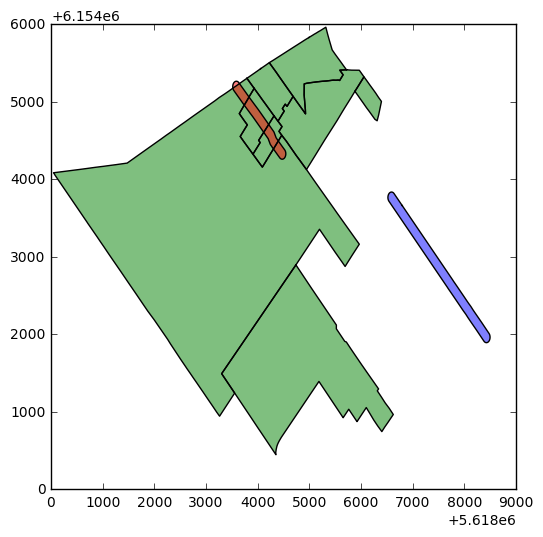

In [16]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
radiosSel.plot(ax=ax,color='green')
calleAislada.plot(ax=ax,color='blue')
calleConectada.plot(ax=ax,color='red')

In [17]:
intersec = gpd.overlay(radiosSel, calleConectada, how='intersection')
intersec

,AREA,DEPARTAMEN,DEPTO_NAME,LINK,Pob,TIPO,densidad,highway,geometry
0,10753800.0,06539,MERLO,065391007,2913,M,0,residential,"POLYGON ((5621831.386868679 6159061.582841514,..."
1,297245.6,06539,MERLO,065391008,2204,U,3,residential,"POLYGON ((5621789.358866802 6159012.434962539,..."
2,10753800.0,06539,MERLO,065391007,2913,M,0,residential,"POLYGON ((5622304.19733424 6158390.687202398, ..."
3,169436.9,06539,MERLO,065391009,1766,U,5,residential,"POLYGON ((5622352.559752863 6158443.872580742,..."


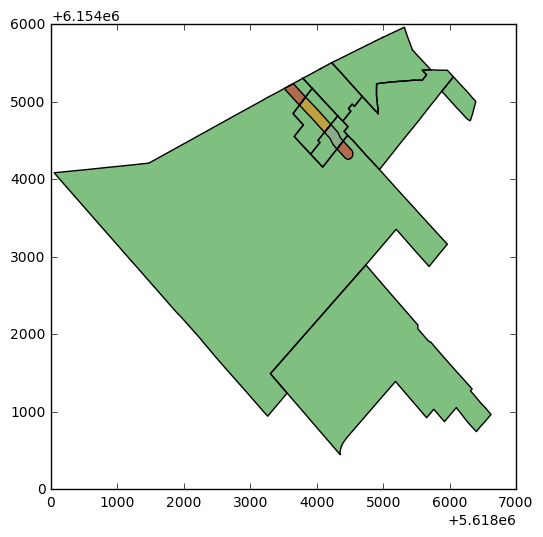

In [18]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
radiosSel.plot(ax=ax,color='green')
intersec.plot(ax=ax,column='LINK')


In [19]:
noIntersec = gpd.overlay(radiosSel, calleAislada, how='intersection')


In [20]:
noIntersec.shape

(0, 0)

In [21]:
calleConectada2 = gpd.read_file('dataPrueba/calleConConexion2.shp')
calleConectada2['buffer'] = calleConectada2.geometry.buffer(70)
calleConectada2.drop(['geometry'],axis=1,inplace=True)
calleConectada2.columns = [u'highway', u'geometry']



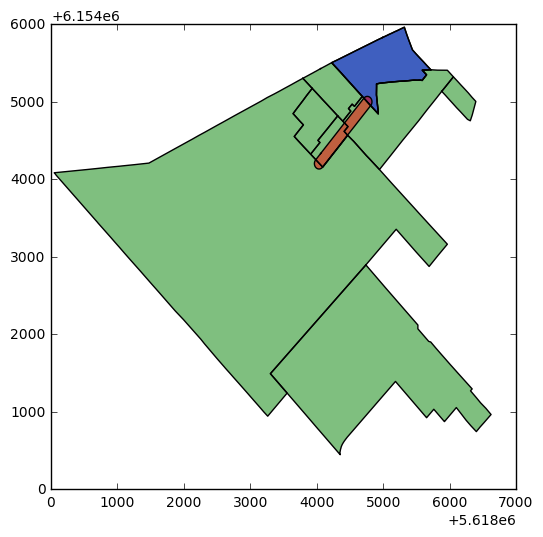

In [22]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
radiosSel.plot(ax=ax,color='green')
radiosSel.loc[radiosSel.LINK == '065391011',:].plot(ax=ax,color='blue')
calleConectada2.plot(ax=ax,color='RED')


In [23]:
intersec2 = gpd.overlay(radiosSel, calleConectada2, how='intersection')
intersec2

,AREA,DEPARTAMEN,DEPTO_NAME,LINK,Pob,TIPO,densidad,highway,geometry
0,10753800.0,06539,MERLO,065391007,2913,M,0,residential,"POLYGON ((5621985.381953466 6158252.55699361, ..."
1,169436.9,06539,MERLO,065391009,1766,U,5,residential,"POLYGON ((5621991.465134294 6158246.843687637,..."
2,985014.2,06539,MERLO,065391016,1801,M,0,residential,"POLYGON ((5622423.833162273 6158721.66510212, ..."
3,709438.6,06539,MERLO,065391011,1698,M,0,residential,"POLYGON ((5622709.271911588 6159046.506834115,..."


In [24]:
appenDF = intersec2.append(intersec)
appenDF

,AREA,DEPARTAMEN,DEPTO_NAME,LINK,Pob,TIPO,densidad,highway,geometry
0,10753800.0,06539,MERLO,065391007,2913,M,0,residential,"POLYGON ((5621985.381953466 6158252.55699361, ..."
1,169436.9,06539,MERLO,065391009,1766,U,5,residential,"POLYGON ((5621991.465134294 6158246.843687637,..."
2,985014.2,06539,MERLO,065391016,1801,M,0,residential,"POLYGON ((5622423.833162273 6158721.66510212, ..."
3,709438.6,06539,MERLO,065391011,1698,M,0,residential,"POLYGON ((5622709.271911588 6159046.506834115,..."
0,10753800.0,06539,MERLO,065391007,2913,M,0,residential,"POLYGON ((5621831.386868679 6159061.582841514,..."
1,297245.6,06539,MERLO,065391008,2204,U,3,residential,"POLYGON ((5621789.358866802 6159012.434962539,..."
2,10753800.0,06539,MERLO,065391007,2913,M,0,residential,"POLYGON ((5622304.19733424 6158390.687202398, ..."
3,169436.9,06539,MERLO,065391009,1766,U,5,residential,"POLYGON ((5622352.559752863 6158443.872580742,..."


In [25]:
appenDFdiss = appenDF.dissolve(by='LINK')


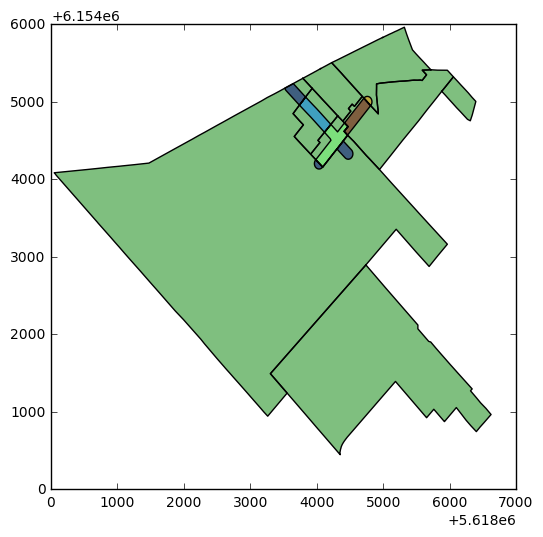

In [26]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
radiosSel.plot(ax=ax,color='green')
appenDFdiss.plot(ax=ax)

###  Ejecución en el total del conjunto de datos

In [29]:
calles.drop(['highway'],axis=1,inplace=True)
calles['calleID'] = calles.index

In [30]:
#spatial join
#a cada calle le asigno el radio al que pertenece
#una calle puede atravesar mas de un radio, por eso van a aparecer calles repedidas en la tabla
calles = gpd.sjoin(calles, agbaBajaDens.loc[:,['geometry','LINK']], how="inner", op='intersects')
calles.reset_index(inplace=True)
calles.drop(['index','index_right'],axis=1,inplace=True)
calles.head()

,geometry,calleID,LINK
0,"POLYGON ((5585797.157224065 6157690.710567379,...",279,063640504
1,"POLYGON ((5585766.893090877 6157819.541789982,...",280,063640504
2,"POLYGON ((5585824.361333102 6157929.274601583,...",281,063640504
3,"POLYGON ((5585928.447176262 6157857.453439912,...",282,063640504
4,"POLYGON ((5585901.694404183 6157967.977852936,...",283,063640504


In [31]:
primerID = calles.calleID.unique()[0]
counter = 0
for i in calles.calleID.unique():
    #para cada calle
    subset = calles.loc[calles.calleID==i,:]
    #selecciono de a una calle
    unaLinea = subset.iloc[0:1,:]
    #de todos los radios, selecciono los que interseccionan esta calle
    conjuntoDeRadios = agbaBajaDens.loc[agbaBajaDens.LINK.isin(subset.LINK),:]
    #realizo una intercepcion
    if i == primerID:
        intercept = gpd.overlay(conjuntoDeRadios, unaLinea, how='intersection')
    else:
        tmp = gpd.overlay(conjuntoDeRadios, unaLinea, how='intersection')
        intercept = intercept.append(tmp)
    counter += 1
        
    print '\r',"%",str((counter+1)*100./len(calles.calleID.unique()))[:4],

% 100.


In [32]:
intercept.head()

,LINK,DEPTO_NAME,mixYden,calleID,LINK_2,geometry
0,063640504,GENERAL RODRIGUEZ,True,279,063640504,"POLYGON ((5585876.703430125 6157766.650889304,..."
0,063640504,GENERAL RODRIGUEZ,True,280,063640504,"POLYGON ((5585816.305761689 6157867.002179299,..."
0,063640504,GENERAL RODRIGUEZ,True,281,063640504,"POLYGON ((5585652.716804017 6158033.904114954,..."
0,063640504,GENERAL RODRIGUEZ,True,282,063640504,"POLYGON ((5585735.918334833 6157949.005015798,..."
0,063640504,GENERAL RODRIGUEZ,True,283,063640504,"POLYGON ((5585654.270403223 6158032.318814625,..."


In [33]:
intercept = intercept.loc[:,['LINK','geometry']]

In [34]:
primerLINKid = intercept.LINK.unique()[0]
for i in intercept.LINK.unique():
    if i == primerLINKid:
        dissolve = intercept.loc[intercept.LINK==i,:].dissolve(by='LINK').reset_index()
    else:
        try:
            tmp = intercept.loc[intercept.LINK==i,:].dissolve(by='LINK').reset_index()
        except:
            #tomo los intercepts dentro de un radio por su LINK
            tmp = intercept.loc[intercept.LINK==i,:]
            #creo el primer elemento de la cascade_union
            geoConError = tmp.geometry.iloc[0]
            for i in range(1,tmp.shape[0]):
                geoConError = shapely.ops.cascaded_union([geoConError,tmp.geometry.iloc[i]])
            tmp = tmp.iloc[0:1,:].reset_index().drop(['index'],axis=1)
            tmp['geometry'][0] = geoConError
            
        dissolve = dissolve.append(tmp)
            


TopologyException: found non-noded intersection between LINESTRING (5.64429e+06 6.13899e+06, 5.64435e+06 6.13908e+06) and LINESTRING (5.64435e+06 6.13908e+06, 5.64434e+06 6.13906e+06) at 5644348.837400442 6139080.3267585943
TopologyException: found non-noded intersection between LINESTRING (5.64429e+06 6.13899e+06, 5.64435e+06 6.13908e+06) and LINESTRING (5.64435e+06 6.13908e+06, 5.64434e+06 6.13906e+06) at 5644348.837400442 6139080.3267585943
TopologyException: found non-noded intersection between LINESTRING (5.60281e+06 6.16622e+06, 5.60283e+06 6.16623e+06) and LINESTRING (5.60281e+06 6.16622e+06, 5.60281e+06 6.16622e+06) at 5602814.4831207125 6166222.2533008074
TopologyException: found non-noded intersection between LINESTRING (5.60281e+06 6.16622e+06, 5.60283e+06 6.16623e+06) and LINESTRING (5.60281e+06 6.16622e+06, 5.60281e+06 6.16622e+06) at 5602814.4831207125 6166222.2533008074
TopologyException: found non-noded intersection between LINESTRING (5.59847e+06 6.17144e+06, 5.59846e+

In [35]:
dissolve = gpd.GeoDataFrame(dissolve, geometry="geometry", crs=agba.crs)
dissolve = dissolve.reset_index().drop(['index'],axis=1)

In [36]:
agbaAltaDens = agbaAltaDens.reset_index().drop(['index','DEPTO_NAME','mixYden'],axis=1)

In [37]:
agbaOSM = agbaAltaDens.append(dissolve)
agbaOSM.head()

,LINK,geometry
0,062520209,"POLYGON ((5612723.096547182 6201186.305513684,..."
1,062520216,"POLYGON ((5611865.994244184 6200953.547424132,..."
2,062520105,"POLYGON ((5610396.67145441 6200626.129762402, ..."
3,062520217,"POLYGON ((5611665.072409396 6200842.464373552,..."
4,062520104,"POLYGON ((5610396.67145441 6200626.129762402, ..."


In [39]:
agbaOSM.to_file('../dt/carto/agbaOSM/')